In [16]:
# Download the modules 

import tensorflow as tf    
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [17]:
#Assign the variables 
IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNEL = 3
EPOCHS = 50
train_split_size = 0.8
test_split_size = 0.1
validate_split_size = 0.1


INPUT_SHAPE = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNEL)
ACTIVATION = 'relu'
KERNAL_SIZE = 3
FILTER_SIZE = 3
POLLING_SIZE = 2
DENSE_ACTIVATION = 'softmax'
n_classes = 2

OPTIMIZER = 'adam'
METRICS = 'accuracy'
VERBOSE = 1

images_directory_name = "kaggle_dataset"
model_save_path = "../saved_models/"

In [18]:
# Download the dataset into the tensorflow dataset
# Check your directory should be in the below format 

# kaggle_dataset
# .....Pepper__bell___Bacterial_spot
#       ..... image_1.jpg
#       ..... image_2.jpg
# .....Pepper__bell___healthy
#       ..... image_1.jpg
#       ..... image_2.jpg


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_directory_name,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2475 files belonging to 2 classes.


In [19]:
# Check the name for the three classes it should be same as the folder classes
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [21]:
# Check the length of the dataset 
# It should be number of images actual in the directory- 2475  
# last batch size it not having exact 32 iamges thats why this number showing graeter value

len(dataset)

310


 32 Batch_size images shape:- (8, 256, 256, 3)

 Labels with repective 32 image:- [1 1 0 1 0 1 0 0]

 Print the first image :- In Tensorflow 
tf.Tensor(
[[[190. 184. 188.]
  [177. 171. 175.]
  [179. 173. 177.]
  ...
  [198. 192. 196.]
  [196. 190. 194.]
  [200. 194. 198.]]

 [[175. 169. 173.]
  [169. 163. 167.]
  [168. 162. 166.]
  ...
  [193. 187. 191.]
  [196. 190. 194.]
  [203. 197. 201.]]

 [[178. 172. 176.]
  [183. 177. 181.]
  [179. 173. 177.]
  ...
  [192. 186. 190.]
  [195. 189. 193.]
  [201. 195. 199.]]

 ...

 [[126. 116. 125.]
  [120. 110. 119.]
  [124. 114. 123.]
  ...
  [126. 116. 124.]
  [130. 120. 128.]
  [127. 117. 125.]]

 [[153. 143. 152.]
  [144. 134. 143.]
  [142. 132. 141.]
  ...
  [138. 128. 136.]
  [143. 133. 141.]
  [140. 130. 138.]]

 [[128. 118. 127.]
  [129. 119. 128.]
  [140. 130. 139.]
  ...
  [157. 147. 155.]
  [146. 136. 144.]
  [154. 144. 152.]]], shape=(256, 256, 3), dtype=float32)

 Print the first iamge :- In Numpy 
[[[190. 184. 188.]
  [177. 171. 17

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

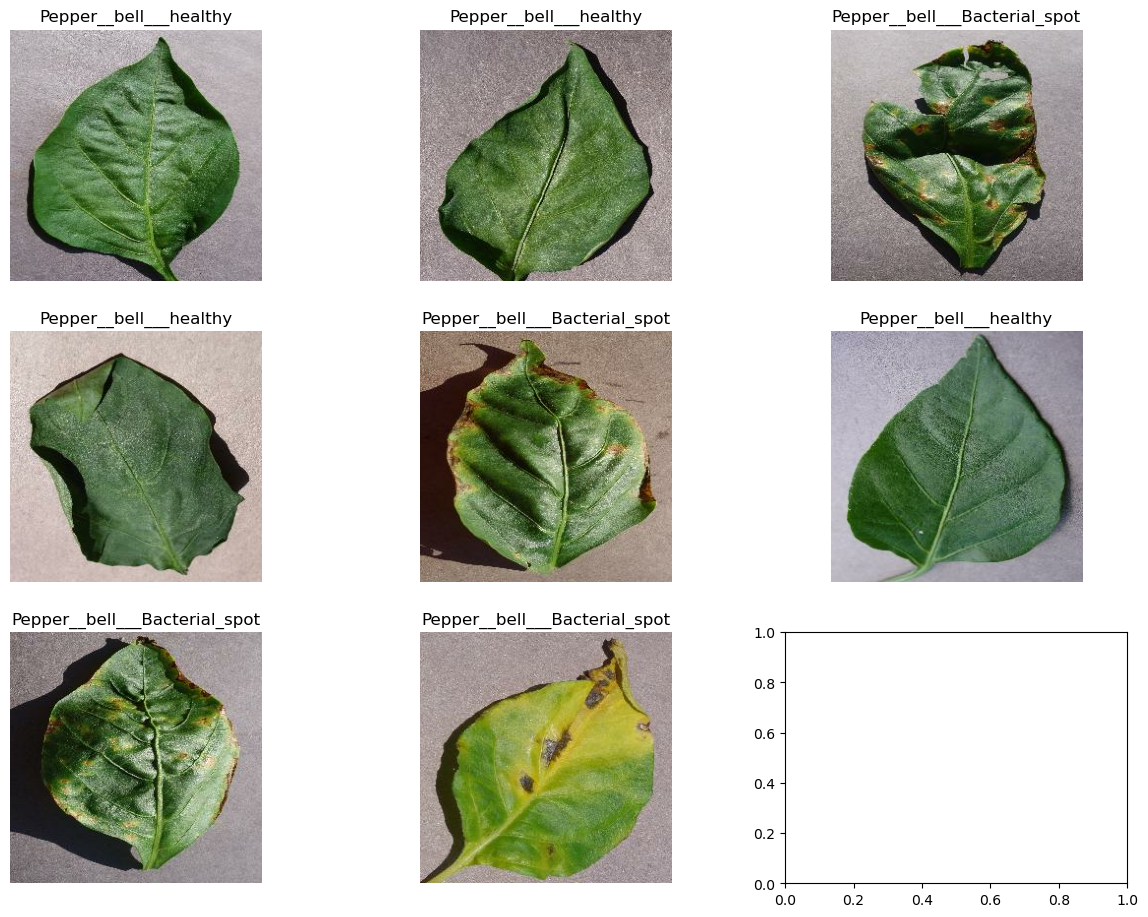

In [22]:
# Load the one batch of the images and labels
plt.figure(figsize = (15,15))

for image_batch , label_batch in dataset.take(1):
    print('\n 32 Batch_size images shape:-' , image_batch.shape)
    print('\n Labels with repective 32 image:-',label_batch.numpy())
    
    print("\n Print the first image :- In Tensorflow ")
    print(image_batch[0])
    
    print("\n Print the first iamge :- In Numpy ")
    print(image_batch[0].numpy())
    
    print("\n Visualize the first 12 images:-")
    for i in range(12):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
    
    

In [23]:
# Split our dataset into Train, Test and validation dataset
# Train dataset split--> 80%
# Test dataset split--> 10%
# Validation dataset split--> 10%


def train_test_split(dataset , train_size = 0.8, validate_size = 0.1,  test_size = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(dataset)
    
    if shuffle :
        dataset = dataset.shuffle(shuffle_size , seed =12)
        
    train_length = int( ds_size * train_size)
    val_length = int(ds_size * validate_size)
    
    
    train_dataset = dataset.take(train_length)
    remain_dataset = dataset.skip(train_length)    
   
    validate_dataset = remain_dataset.take(val_length)
    test_dataset =  remain_dataset.skip(val_length)
    
    return train_dataset , validate_dataset, test_dataset  

In [24]:
train_dataset , validate_dataset, test_dataset  = train_test_split(dataset , 
                                                                   train_size = train_split_size, 
                                                                   validate_size = validate_split_size,
                                                                   test_size = test_split_size)

In [25]:
# To increase the performance of the pipeline
# Perform Caching - It will read the image from menory after the first read
# prefetching -- save the time reading the images

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validate_dataset = validate_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [26]:
# Preprocessing pipeline
# 1. Resize Image bys the IMAGE_SIZE - help while testing
# 2. Rescale Imge by Divide the 255

resize_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [27]:
# Data augumentation
# Perform horizontal and vertical flip and rotatation.
# Here I have added another augumentation that is Zoom

data_augumentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2), 
    layers.experimental.preprocessing.RandomZoom(0.5, 0.2)
    
])

In [28]:
# Create the convolution Neural Network Model
# The layers used in the CNN model are 
# -----convolution layers
# -----Max pooling layers
# -----Flatten layer
# -----Dense layer -> softmax function normalize the probability of the classes


model = models.Sequential([
    resize_rescale_layer,
    data_augumentation_layer,
    layers.Conv2D(32,(FILTER_SIZE,FILTER_SIZE), activation = ACTIVATION, input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , kernel_size = (KERNAL_SIZE, KERNAL_SIZE), activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , kernel_size = (KERNAL_SIZE,KERNAL_SIZE), activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , (FILTER_SIZE,FILTER_SIZE) , activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , (FILTER_SIZE,FILTER_SIZE) , activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , (FILTER_SIZE,FILTER_SIZE),  activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Flatten(),
    layers.Dense(n_classes , activation = DENSE_ACTIVATION)  
])

model.build(input_shape = INPUT_SHAPE)

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (8, 256, 256, 3)          0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [30]:
# Compile the model
model.compile(
    optimizer = OPTIMIZER,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = [METRICS],
)

In [31]:
# Train user model after compile
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = VERBOSE ,
    validation_data = validate_dataset,    
)

Epoch 1/50
248/248 [==============================] - 173s 655ms/step - loss: 0.5548 - accuracy: 0.7049 - val_loss: 0.4547 - val_accuracy: 0.7901
Epoch 2/50
248/248 [==============================] - 151s 609ms/step - loss: 0.2407 - accuracy: 0.9050 - val_loss: 0.1837 - val_accuracy: 0.9588
Epoch 3/50
248/248 [==============================] - 152s 614ms/step - loss: 0.0730 - accuracy: 0.9773 - val_loss: 0.0648 - val_accuracy: 0.9753
Epoch 4/50
248/248 [==============================] - 150s 605ms/step - loss: 0.0787 - accuracy: 0.9757 - val_loss: 0.1126 - val_accuracy: 0.9671
Epoch 5/50
248/248 [==============================] - 151s 610ms/step - loss: 0.0539 - accuracy: 0.9843 - val_loss: 0.0170 - val_accuracy: 0.9918
Epoch 6/50
248/248 [==============================] - 162s 655ms/step - loss: 0.0434 - accuracy: 0.9879 - val_loss: 0.0468 - val_accuracy: 0.9918
Epoch 7/50
248/248 [==============================] - 158s 639ms/step - loss: 0.0436 - accuracy: 0.9884 - val_loss: 0.0310 -

Epoch 11/50
248/248 [==============================] - 177s 712ms/step - loss: 0.0225 - accuracy: 0.9944 - val_loss: 0.0393 - val_accuracy: 0.9877
Epoch 12/50
248/248 [==============================] - 167s 675ms/step - loss: 0.0289 - accuracy: 0.9914 - val_loss: 0.1331 - val_accuracy: 0.9424
Epoch 13/50
248/248 [==============================] - 165s 666ms/step - loss: 0.0432 - accuracy: 0.9843 - val_loss: 0.0069 - val_accuracy: 0.9959
Epoch 14/50
248/248 [==============================] - 168s 678ms/step - loss: 0.0467 - accuracy: 0.9869 - val_loss: 0.0125 - val_accuracy: 0.9959
Epoch 15/50
248/248 [==============================] - 179s 721ms/step - loss: 0.0235 - accuracy: 0.9939 - val_loss: 0.0294 - val_accuracy: 0.9877
Epoch 16/50
248/248 [==============================] - 179s 720ms/step - loss: 0.0292 - accuracy: 0.9899 - val_loss: 0.0136 - val_accuracy: 0.9918
Epoch 17/50
248/248 [==============================] - 187s 753ms/step - loss: 0.0401 - accuracy: 0.9904 - val_loss: 0

In [32]:
# Run on the Test dataset to check the model accuracy
model.evaluate(test_dataset)

31/31 [==============================] - 10s 136ms/step - loss: 0.0180 - accuracy: 0.9960


[0.01796121336519718, 0.9959677457809448]

In [33]:
# History --> It is keras callback history

accuracy = history.history['accuracy']
vaidation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

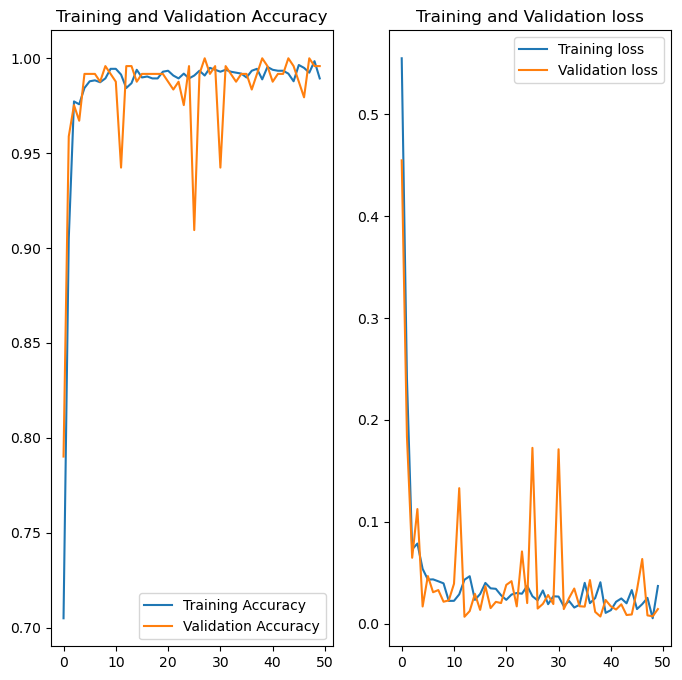

In [34]:
# Plot the Training and Validation Accuracy chart

plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy , label = 'Training Accuracy')
plt.plot(range(EPOCHS), vaidation_accuracy , label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Plot the Training and Validation loss chart
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss , label = 'Training loss')
plt.plot(range(EPOCHS), validation_loss , label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict:--

 Actual Label for the first image :- Pepper__bell___healthy
1/1 [==============================] - 1s 824ms/step
Predicted Label for the first image :- Pepper__bell___healthy


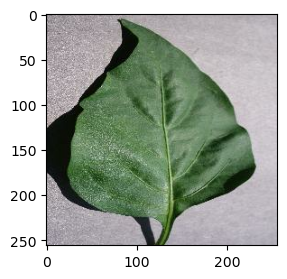

In [35]:
# Predict the test images 
for image_batch , label_batch in test_dataset.take(1):
    plt.figure(figsize=(3,3))
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to predict:--")
    plt.imshow(first_image)
    print("\n Actual Label for the first image :-", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    predicted_label_first = class_names[np.argmax(batch_prediction[0])]
    print("Predicted Label for the first image :-",predicted_label_first)    
    


In [36]:
# Create function to predict the image with specific model

def predict(model , images):
    img_array = tf.keras.preprocessing.image.img_to_array(images) # Converted image to array
    img_array = tf.expand_dims(img_array , 0) # Created batch 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])) ,2)
    return predicted_class , confidence

1/1 [==============================] - 0s 29ms/step


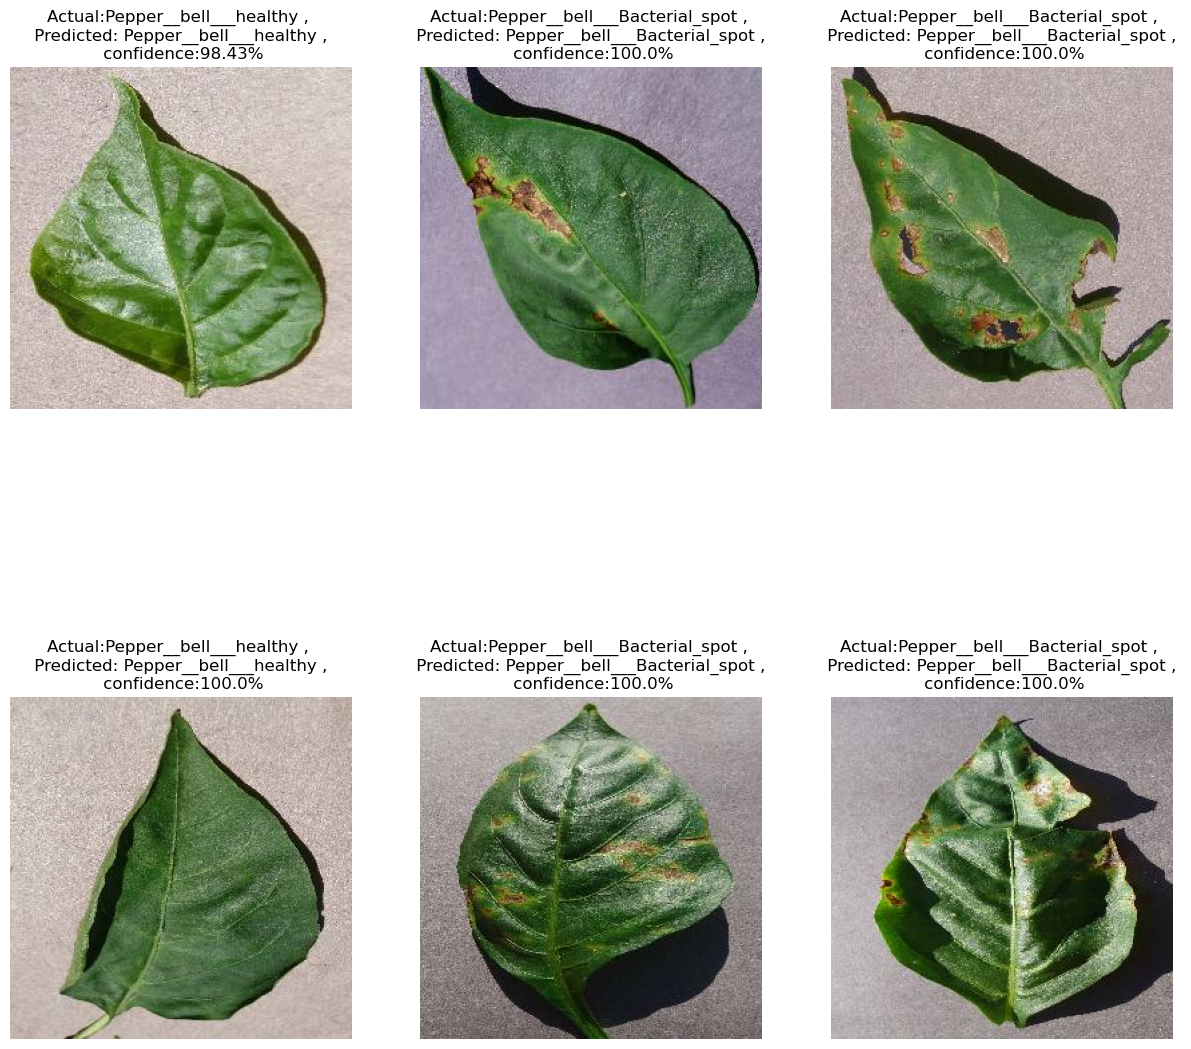

In [40]:
plt.figure(figsize=(15,15))
for image_batch , label_batch in test_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict(model , image_batch[i].numpy())
        actual_class = class_names[label_batch[i]]
        
        plt.title(f"Actual:{actual_class} , \n Predicted: {predicted_class} , \n confidence:{confidence}%")
        plt.axis('off')

In [42]:
# save Models  
# Model version will be auto increment 

model_version = max(int(i) for i in os.listdir(model_save_path)+[0] ) + 1
model.save(f"{model_save_path}{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
